In [2]:
!kaggle competitions download -c best-home2

100%|█████████████████████████████████████▉| 32.0M/32.0M [00:15<00:00, 2.75MB/s]
100%|██████████████████████████████████████| 32.0M/32.0M [00:15<00:00, 2.23MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('best-home2.zip', 'r') as zip_ref:
    zip_ref.extractall('homes')

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv('homes/train.csv')

test_df = pd.read_csv('homes/test.csv')
init_test = test_df.copy()

In [6]:
test_df.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,low,2.0,3,87c4e08083ac83618dd9fdbf849331fe,2016-06-21 03:21:59,Rent listed is net effective after one month f...,E 77 St.,"['Pre-War', 'Laundry in Unit', 'Dishwasher', '...",40.7716,7189305,-73.9544,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7189305_f47ed5c...,4675,339 E 77 St.
1,low,1.0,2,850c3d4412aebb3335273ed95f3e4bd4,2016-06-11 03:47:06,A FABULOUS 2BR IN THE UPPER EAST SIDE! PERFECT...,E 112 Street,[],40.7944,7140670,-73.9401,3e9f0fa34d67e5d61aae56776ecb8cee,['https://photos.renthop.com/2/7140670_6c5824f...,2100,252 E 112 Street
2,low,1.0,2,84ddf917a091828ab9baedc0c926470e,2016-04-17 02:45:19,This is a great true 2 bedroom in a prime Midt...,Ninth Avenue,"['Dogs Allowed', 'Cats Allowed']",40.7650,6886239,-73.9882,10b1ae0a38d50b7ba0cee612d14af9eb,['https://photos.renthop.com/2/6886239_533bbee...,2800,783 Ninth Avenue
3,high,2.0,3,315a2f868a195b076e5be73411110da2,2016-05-07 11:44:35,Brand new custom renovation in beautiful three...,East 12th street,"['Laundry In Unit', 'No Fee', 'Washer/Dryer in...",40.7288,6981146,-73.9808,e9920062e07ee893c10e38d0259665b0,['https://photos.renthop.com/2/6981146_f4a7400...,5500,186 Avenue B
4,medium,1.0,3,9b525bacc8d294728c35f27c04e22f46,2016-06-24 07:33:26,"Welcome Home! Located on a Prime UWS Block, Ba...",West 86th&Columbus,"['Private Outdoor Space', 'Elevator', 'Laundry...",40.7864,7210864,-73.9713,6d389fbe372d4d30b17733caa9370f95,['https://photos.renthop.com/2/7210864_e8528f4...,3995,47 West 86th street


In [4]:
train_df.columns

Index(['Id', 'bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'TARGET'],
      dtype='object')

In [5]:
target = 'TARGET'

drop_columns = ['Id', 'photos', 'building_id', 'manager_id', 
                'description', 'display_address', 'listing_id', 'street_address']
num_columns = [
    'bathrooms', 'bedrooms', 
    'latitude', 'listing_id', 'longitude', 
    'price'
]

In [6]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.2, random_state=42)

In [7]:
classes = {'low': 0, 'medium': 1, 'high': 2}

In [8]:
X_train = train[num_columns]
X_val = val[num_columns]

y_train = train[target].map(classes)
y_val = val[target].map(classes)

Посмотрим, какую точность дает модель логрегрессии только на числовых данных:

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

reg = LogisticRegression().fit(X_train, y_train)

y_preds = reg.predict(X_val)
accuracy_score(y_val, y_preds)

0.7013024602026049

Видим, что датасет немного несбалансирован

In [10]:
train_df[target].value_counts()

low       23999
medium     7860
high       2687
Name: TARGET, dtype: int64

In [11]:
train = train_df.copy()

Для начала сделаем для каждого значения features свою колонку:

In [12]:
train['features'] = train['features'].str.replace("[", "")
train['features'] = train['features'].str.replace("]", "")
train['features'] = train['features'].str.replace("'", "")
train['features'] = train['features'].str.replace("\*\*", "")
train['features'] = train['features'].str.replace("\.", "")
train['features'] = train['features'].str.replace('"', "")
train['features'] = train['features'].str.replace(" •", ", ")
train['features'] = train['features'].str.replace(" \*", ", ")
train['features'] = train['features'].str.lower()
train['features'] = train['features'].str.strip()

In [13]:
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [14]:
X_train = train.drop(columns=drop_columns + [target, 'created'])
y_train = train[target].map(classes)

X_val = val.drop(columns=drop_columns + [target, 'created'])
y_val = val[target].map(classes)

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

X_train = X_train.join(
    pd.DataFrame(mlb.fit_transform(X_train['features'].str.split(', ')), 
                 index=X_train.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

X_val = X_val.join(
    pd.DataFrame(mlb.transform(X_val['features'].str.split(', ')), 
                 index=X_val.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

Смогли немного улучшить результат:

In [16]:
reg = LogisticRegression().fit(X_train, y_train)

y_preds = reg.predict(X_val)
accuracy_score(y_val, y_preds)

0.7057887120115774

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [18]:
reg = LogisticRegression().fit(X_train, y_train)

y_preds = reg.predict(X_val)
accuracy_score(y_val, y_preds)

0.7088277858176556

Видим, что стандартизация тоже помогает увеличить точность. Теперь преобразуем признак created - дату создания:

In [19]:
train['created'] = pd.to_datetime(train['created'])
val['created'] = pd.to_datetime(val['created'])

train['created'] = train['created'].dt.year * 100 + train['created'].dt.month
val['created'] = val['created'].dt.year * 100 + val['created'].dt.month

In [20]:
X_train = train.drop(columns=drop_columns + [target])
y_train = train[target].map(classes)

X_val = val.drop(columns=drop_columns + [target])
y_val = val[target].map(classes)

In [21]:
mlb = MultiLabelBinarizer()

X_train = X_train.join(
    pd.DataFrame(mlb.fit_transform(X_train['features'].str.split(', ')), 
                 index=X_train.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

X_val = X_val.join(
    pd.DataFrame(mlb.transform(X_val['features'].str.split(', ')), 
                 index=X_val.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

In [22]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [23]:
reg = LogisticRegression().fit(X_train, y_train)

y_preds = reg.predict(X_val)
accuracy_score(y_val, y_preds)

0.7092619392185239

Снова незначительно улучшили результат

In [24]:
train = train_df.copy()

train, val = train_test_split(train, test_size=0.2, random_state=42)

Добавим признак "расстояние до центра города":

In [25]:
center_lat = 40.7143
center_lng = -74.006

train['dist_from_center'] = np.square((train['latitude'] - center_lat)) + \
                            np.square((train['longitude'] - center_lat))

val['dist_from_center'] = np.square((val['latitude'] - center_lat)) + \
                            np.square((val['longitude'] - center_lat))

In [26]:
train['created'] = pd.to_datetime(train['created'])
val['created'] = pd.to_datetime(val['created'])

train['created'] = train['created'].dt.year * 100 + train['created'].dt.month
val['created'] = val['created'].dt.year * 100 + val['created'].dt.month

In [27]:
X_train = train.drop(columns=drop_columns + [target])
y_train = train[target].map(classes)

X_val = val.drop(columns=drop_columns + [target])
y_val = val[target].map(classes)

In [28]:
mlb = MultiLabelBinarizer()

X_train = X_train.join(
    pd.DataFrame(mlb.fit_transform(X_train['features'].str.split(', ')), 
                 index=X_train.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

X_val = X_val.join(
    pd.DataFrame(mlb.transform(X_val['features'].str.split(', ')), 
                 index=X_val.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

In [29]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [30]:
reg = LogisticRegression().fit(X_train, y_train)

y_preds = reg.predict(X_val)
accuracy_score(y_val, y_preds)

0.7120115774240231

Новый признак оказался полезным и улучшил результат. Добавим также произведение признаков "количество спален" и "стоимость":

In [31]:
train['price_bedroom'] = train['bedrooms'] * train['price']
val['price_bedroom'] = val['bedrooms'] * val['price']

In [32]:
X_train = train.drop(columns=drop_columns + [target])
y_train = train[target].map(classes)

X_val = val.drop(columns=drop_columns + [target])
y_val = val[target].map(classes)

In [33]:
mlb = MultiLabelBinarizer()

X_train = X_train.join(
    pd.DataFrame(mlb.fit_transform(X_train['features'].str.split(', ')), 
                 index=X_train.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

X_val = X_val.join(
    pd.DataFrame(mlb.transform(X_val['features'].str.split(', ')), 
                 index=X_val.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

In [34]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [35]:
reg = LogisticRegression().fit(X_train, y_train)

y_preds = reg.predict(X_val)
accuracy_score(y_val, y_preds)

0.7120115774240231

Попробуем другие модели на тех же данных:

In [36]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
y_preds = tree.predict(X_val)
accuracy_score(y_val, y_preds)

0.6633863965267728

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

knn.fit(X_train, y_train)
y_preds = knn.predict(X_val)
accuracy_score(y_val, y_preds)

0.6704775687409551

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

forest.fit(X_train, y_train)
y_preds = forest.predict(X_val)
accuracy_score(y_val, y_preds)

0.7227206946454414

Случайный лес дает лучший результат, попробуем подобрать гиперпараметры для него:

In [39]:
depths = np.arange(20, 60)
scores = np.array([])

for depth in depths:
    forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=depth, random_state=42)
    forest.fit(X_train, y_train)
    y_preds = forest.predict(X_val)
    scores = np.append(scores, accuracy_score(y_val, y_preds))

Text(0, 0.5, 'Значение accuracy')

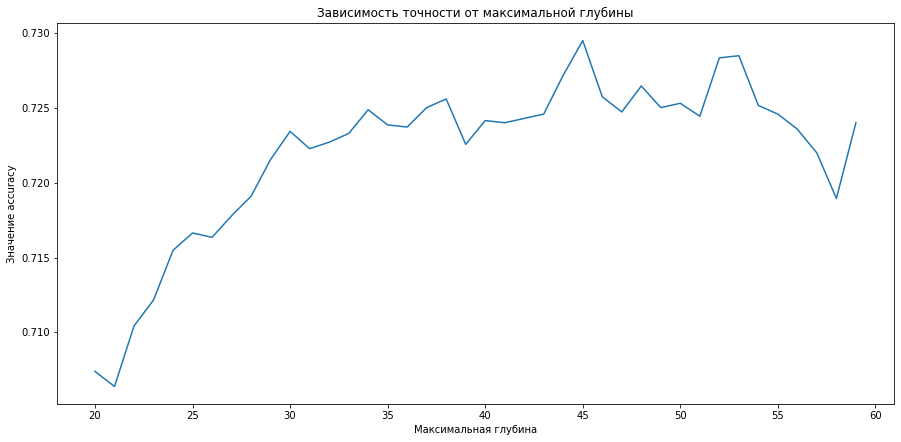

In [40]:
plt.figure(figsize=(15, 7))
plt.plot(depths, scores)
plt.title("Зависимость точности от максимальной глубины")
plt.xlabel("Максимальная глубина")
plt.ylabel("Значение accuracy")

In [41]:
depth = depths[scores.argmax()]

In [42]:
n_samples_arr = np.arange(1, 20)
scores = np.array([])

for n_samples in n_samples_arr:
    forest = RandomForestClassifier(n_estimators=50, 
                                    n_jobs=-1, 
                                    max_depth=depth, 
                                    random_state=42, 
                                    min_samples_leaf=n_samples)
    forest.fit(X_train, y_train)
    y_preds = forest.predict(X_val)
    scores = np.append(scores, accuracy_score(y_val, y_preds))

Text(0, 0.5, 'Значение accuracy')

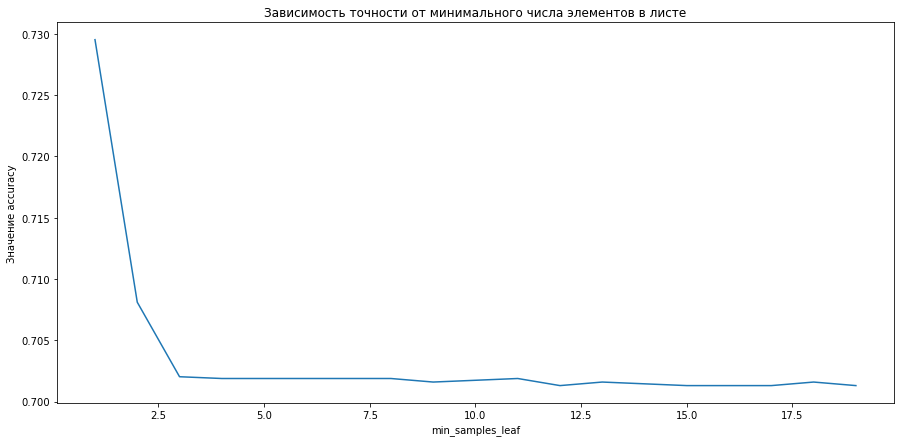

In [43]:
plt.figure(figsize=(15, 7))
plt.plot(n_samples_arr, scores)
plt.title("Зависимость точности от минимального числа элементов в листе")
plt.xlabel("min_samples_leaf")
plt.ylabel("Значение accuracy")

Полученную модель используем для предсказаний на тестовой выборке:

In [44]:
train_df['dist_from_center'] = np.square((train_df['latitude'] - center_lat)) + \
                            np.square((train_df['longitude'] - center_lat))

test_df['dist_from_center'] = np.square((test_df['latitude'] - center_lat)) + \
                            np.square((test_df['longitude'] - center_lat))

train_df['created'] = pd.to_datetime(train_df['created'])
test_df['created'] = pd.to_datetime(test_df['created'])

train_df['created'] = train_df['created'].dt.year * 100 + train_df['created'].dt.month
test_df['created'] = test_df['created'].dt.year * 100 + test_df['created'].dt.month

train_df['price_bedroom'] = train_df['bedrooms'] * train_df['price']
test_df['price_bedroom'] = test_df['bedrooms'] * test_df['price']

In [45]:
X_train = train_df.drop(columns=drop_columns + [target])
y_train = train_df[target].map(classes)

X_test = test_df.drop(columns=drop_columns)

In [46]:
mlb = MultiLabelBinarizer()

X_train = X_train.join(
    pd.DataFrame(mlb.fit_transform(X_train['features'].str.split(', ')), 
                 index=X_train.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

X_test = X_test.join(
    pd.DataFrame(mlb.transform(X_test['features'].str.split(', ')), 
                 index=X_test.index, 
                 columns=mlb.classes_)).drop(columns=['features'])

In [47]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=depth, random_state=42)
forest.fit(X_train, y_train)

y_preds = forest.predict(X_test)

In [58]:
submit = pd.DataFrame.from_dict({'Id':init_test.Id.values, 'TARGET': y_preds})
classes_reverse = {0: 'low', 1: 'medium', 2: 'high'}
submit['TARGET'] = submit['TARGET'].map(classes_reverse)
submit.to_csv("sumbit.csv", index=False)